In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load and preprocess the data

In [ ]:
data = pd.read_csv('/Users/julialorenc/Desktop/BAN443_LLMs/FINAL_PROJECT/processed_reports.csv')

In [ ]:
data.head()

,year,month,district,report,tone
0,1997,1,Atlanta,"Beige Book Report: Atlanta January 22, 1997 ...",0.380952
1,1997,1,Boston,"Beige Book Report: Boston January 22, 1997 T...",0.207547
2,1997,1,Chicago,"Beige Book Report: Chicago January 22, 1997 ...",0.125000
3,1997,1,Cleveland,"Beige Book Report: Cleveland January 22, 199...",0.333333
4,1997,1,Dallas,"Beige Book Report: Dallas January 22, 1997 I...",0.264151


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      2671 non-null   int64  
 1   month     2671 non-null   int64  
 2   district  2671 non-null   object 
 3   report    2671 non-null   object 
 4   tone      2671 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 104.5+ KB


### Pivot the data frame to have districts as columns (labels)

In [ ]:
data = data.pivot_table(index=["year", "month"], columns="district", values="tone", aggfunc='mean').reset_index()
data.head()

district,year,month,Atlanta,Boston,Chicago,Cleveland,Dallas,Kansas City,Minneapolis,New York,Philadelphia,Richmond,San Francisco,St. Louis
0,1997,1,0.380952,0.207547,0.125000,0.333333,0.264151,0.214286,0.196721,0.318182,0.371429,-0.049180,0.382353,0.420000
1,1997,3,0.333333,0.288462,-0.052632,0.106383,0.122807,0.477273,0.305085,0.340000,0.204545,0.228070,0.488889,-0.046512
2,1997,5,0.333333,0.363636,0.183333,0.121951,0.210526,0.297872,0.242424,-0.093023,0.414634,0.313433,0.489362,-0.083333
3,1997,6,0.196078,0.294118,0.215385,-0.050000,0.101695,0.360000,0.258065,0.377778,0.292683,0.157895,0.390244,0.019608
4,1997,8,0.255319,0.333333,0.208333,0.105263,0.406780,0.304348,0.333333,0.095238,0.357143,0.192308,0.380952,0.166667


### Label the recession periods

In [ ]:
data["recession"] = 0

data.loc[(data["year"] == 2001) & (data["month"] >= 3) & (data["month"] <= 11), "recession"] = 1
data.loc[(data["year"] == 2008) | ((data["year"] == 2009) & (data["month"] <= 6)), "recession"] = 1
data.loc[(data["year"] == 2020) & (data["month"].isin([3, 4])), "recession"] = 1

In [ ]:
data.head()

district,year,month,Atlanta,Boston,Chicago,Cleveland,Dallas,Kansas City,Minneapolis,New York,Philadelphia,Richmond,San Francisco,St. Louis,recession
0,1997,1,0.380952,0.207547,0.125000,0.333333,0.264151,0.214286,0.196721,0.318182,0.371429,-0.049180,0.382353,0.420000,0
1,1997,3,0.333333,0.288462,-0.052632,0.106383,0.122807,0.477273,0.305085,0.340000,0.204545,0.228070,0.488889,-0.046512,0
2,1997,5,0.333333,0.363636,0.183333,0.121951,0.210526,0.297872,0.242424,-0.093023,0.414634,0.313433,0.489362,-0.083333,0
3,1997,6,0.196078,0.294118,0.215385,-0.050000,0.101695,0.360000,0.258065,0.377778,0.292683,0.157895,0.390244,0.019608,0
4,1997,8,0.255319,0.333333,0.208333,0.105263,0.406780,0.304348,0.333333,0.095238,0.357143,0.192308,0.380952,0.166667,0


### Drop redundant `year` and `month` columns

In [ ]:
data.drop(columns=['year', 'month'], inplace=True)
data.head()

district,Atlanta,Boston,Chicago,Cleveland,Dallas,Kansas City,Minneapolis,New York,Philadelphia,Richmond,San Francisco,St. Louis,recession
0,0.380952,0.207547,0.125000,0.333333,0.264151,0.214286,0.196721,0.318182,0.371429,-0.049180,0.382353,0.420000,0
1,0.333333,0.288462,-0.052632,0.106383,0.122807,0.477273,0.305085,0.340000,0.204545,0.228070,0.488889,-0.046512,0
2,0.333333,0.363636,0.183333,0.121951,0.210526,0.297872,0.242424,-0.093023,0.414634,0.313433,0.489362,-0.083333,0
3,0.196078,0.294118,0.215385,-0.050000,0.101695,0.360000,0.258065,0.377778,0.292683,0.157895,0.390244,0.019608,0
4,0.255319,0.333333,0.208333,0.105263,0.406780,0.304348,0.333333,0.095238,0.357143,0.192308,0.380952,0.166667,0


## XGBoost model

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Atlanta        223 non-null    float64
 1   Boston         223 non-null    float64
 2   Chicago        223 non-null    float64
 3   Cleveland      223 non-null    float64
 4   Dallas         220 non-null    float64
 5   Kansas City    222 non-null    float64
 6   Minneapolis    222 non-null    float64
 7   New York       223 non-null    float64
 8   Philadelphia   223 non-null    float64
 9   Richmond       223 non-null    float64
 10  San Francisco  223 non-null    float64
 11  St. Louis      223 non-null    float64
 12  recession      223 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 22.8 KB


In [ ]:
data_copy = data.copy()

### Stratified train-test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = data_copy.drop(columns=['recession'])
y = data_copy['recession']

imputer = SimpleImputer(strategy='mean') # Impute any missing values with the mean
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### SMOTE sampling to balance the classes

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Train the model

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)

model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Get a classifiaction report

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        41
           1       0.60      0.75      0.67         4

    accuracy                           0.93        45
   macro avg       0.79      0.85      0.81        45
weighted avg       0.94      0.93      0.94        45

ROC-AUC: 0.97


### Check if not overfitted

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train_smote)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# 0.07 percentage points difference between training and validation datasets - no overfitting

Training Accuracy: 1.00


## SHAP for model interpretation

In [ ]:
import shap

explainer = shap.Explainer(model, X_train_smote)
shap_values = explainer(X_test)

In [ ]:
feature_names = ["Atlanta", "Boston", "Chicago", "Cleveland", "Dallas", "Kansas City", "Minneapolis", "New York", "Philadelphia", "Richmond", "San Francisco", "St Louis"]
X_test_shap = pd.DataFrame(X_test, columns=feature_names)

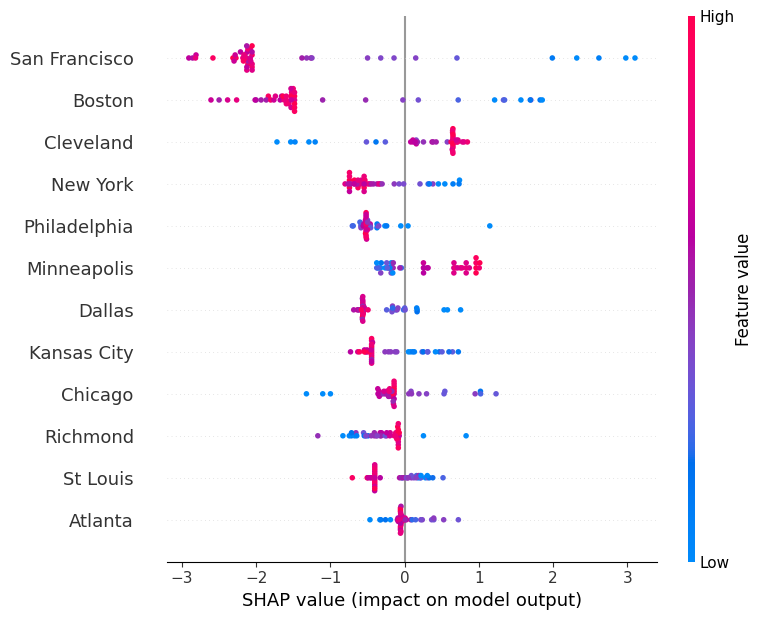

In [ ]:
shap.summary_plot(shap_values, X_test_shap)

## Evaluate on December 2024 beigebook
Should be marked as class 0

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/BAN443_project/DECEMBER_FINETUNED_Beige_Book_sentiment_scores.csv")
test_data.head()

,Unnamed: 0,year,month,Atlanta,Boston,Chicago,Cleveland,Dallas,Kansas City,Minneapolis,New York,Philadelphia,Richmond,San Francisco,St Louis
0,0,2024,12,0.059395,-0.068744,0.172076,0.207816,0.10994,0.163787,0.068427,0.220844,0.140239,-0.226022,0.12256,-0.079859


In [ ]:
test_data.drop(columns=["Unnamed: 0", "year", "month"], inplace = True)

In [ ]:
pred_dec = model.predict(test_data)
print(pred_dec)

[0]
